# Task 1 : Set up colab gpu runtime environment

In [ ]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

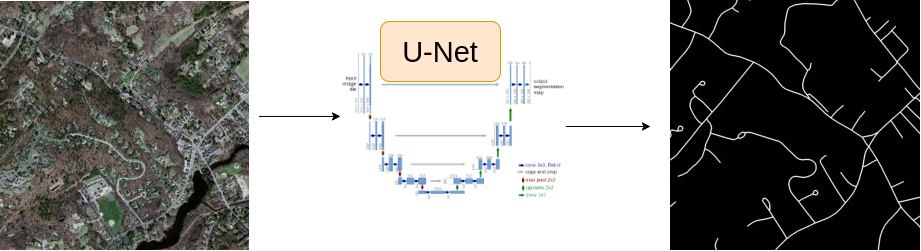

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 24.47 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 13
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255


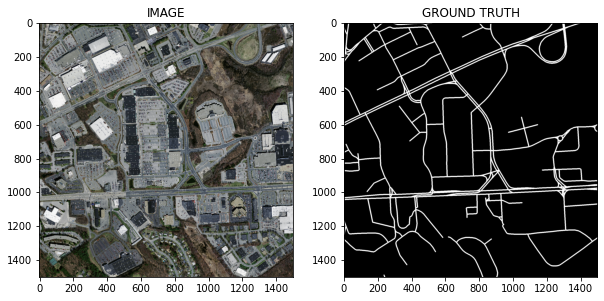

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5)
                    ])
  
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
      ])



# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE ) #(h,w)
    mask = np.expand_dims(mask, axis = -1) #(h,w,c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask )
      image = data['image'] # (h,w,c)
      mask = data['mask']
    
    image = np.transpose(image, (2,0,1)).astype(np.float32) # torch permutena :D 
    mask = np.transpose(mask, (2,0,1)).astype(np.float32) # torch permutena :D 

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(len(trainset), len(validset))

159 40


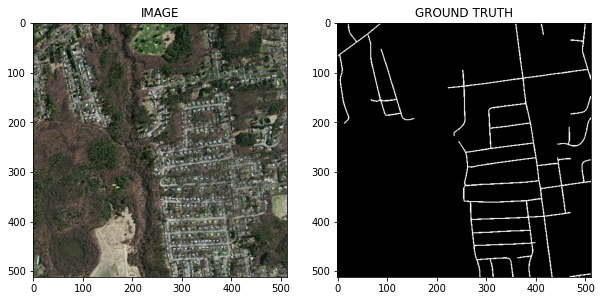

In [ ]:
idx = 78
image, mask = trainset[idx] 

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f'Total number of batches in Trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in Trainloader : 20
Total number of batches in validloader : 5


In [ ]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
pip install segmentation_models_pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=dfd92b12f7d21e6f83ec8b337858d5e68a6944a8a6f593dc386938acd232cb27
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=c00eed6a69aeccd9cc1b46ae9d6ca5c0363e8e9c01003a238d5a8940e89cf9fa
  Stored in directory: /root/.cache/pip/w

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER, 
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  
  def forward(self, images, masks = None):
    
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits
  


In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train() #turn on dropout, batchnorm etc
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(dataloader)


In [ ]:
def eval_fn(dataloader, model):
  model.eval() #turn off dropout, batchnorm etc
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  
  return total_loss / len(dataloader)


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf
print("np.Inf Best Loss : ", best_loss)
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("Saved-Model")
    best_loss = valid_loss
  print(f'Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')

print(f"best loss : {best_loss} ")

100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Saved-Model
Epoch : 1 Train Loss : 1.1691394478082657 Valid Loss : 1.0333700895309448


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Saved-Model
Epoch : 2 Train Loss : 0.7842022508382798 Valid Loss : 0.899964427947998


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Saved-Model
Epoch : 3 Train Loss : 0.7056798309087753 Valid Loss : 0.7709923624992371


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Saved-Model
Epoch : 4 Train Loss : 0.6667814254760742 Valid Loss : 0.7156589269638062


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Saved-Model
Epoch : 5 Train Loss : 0.6506683528423309 Valid Loss : 0.6588588953018188


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 6 Train Loss : 0.6435411244630813 Valid Loss : 0.748036241531372


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 7 Train Loss : 0.6391663432121277 Valid Loss : 0.6773019313812256


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 8 Train Loss : 0.6173020511865616 Valid Loss : 0.6687025427818298


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 9 Train Loss : 0.6146503746509552 Valid Loss : 0.6624881505966187


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Saved-Model
Epoch : 10 Train Loss : 0.6086029753088951 Valid Loss : 0.6361002087593078


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 11 Train Loss : 0.5924675554037094 Valid Loss : 0.63673175573349


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 12 Train Loss : 0.6044392600655556 Valid Loss : 0.6525656104087829


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 13 Train Loss : 0.5936868548393249 Valid Loss : 0.6461419463157654


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Saved-Model
Epoch : 14 Train Loss : 0.5921045541763306 Valid Loss : 0.6315767645835877


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Saved-Model
Epoch : 15 Train Loss : 0.5868562221527099 Valid Loss : 0.6215662598609925


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 16 Train Loss : 0.5832365304231644 Valid Loss : 0.6343501806259155


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 17 Train Loss : 0.5849228218197823 Valid Loss : 0.6541422128677368


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 18 Train Loss : 0.576561439037323 Valid Loss : 0.6349172472953797


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 19 Train Loss : 0.5763206511735917 Valid Loss : 0.6711681365966797


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 20 Train Loss : 0.57300613373518 Valid Loss : 0.6271979212760925


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 21 Train Loss : 0.5667626515030861 Valid Loss : 0.6217395424842834


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Saved-Model
Epoch : 22 Train Loss : 0.5594694286584854 Valid Loss : 0.6081492304801941


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 23 Train Loss : 0.5604261070489883 Valid Loss : 0.6208327174186706


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 24 Train Loss : 0.5539388969540596 Valid Loss : 0.6240582466125488


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

Epoch : 25 Train Loss : 0.5593419969081879 Valid Loss : 0.6144002199172973


# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('/content/best-model.pt'))

<All keys matched successfully>

torch.Size([1, 512, 512])


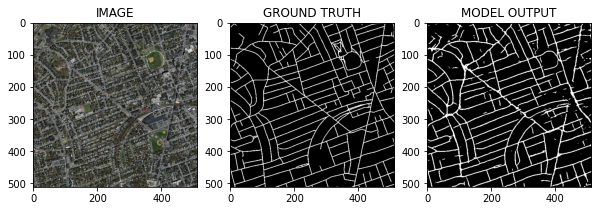

In [ ]:
idx = 30
image, mask = validset[idx] 
print(mask.size())
logits_mask = model(image.to(DEVICE).unsqueeze(0)) 
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))